In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import src.resnet.utils as utils


data = utils.import_csv()
train_data, val_data = utils.split_data(data=data)

In [3]:
from src.resnet.dataloader.mygo_dataloader import dataset_transform, data_loader
train_data_transformed = dataset_transform(data=train_data, mode="train")
val_data_transformed = dataset_transform(data=val_data, mode="val")
train_loader = data_loader(tranformed_dataset=train_data_transformed, batch_size=16, num_workers=1, shuffle=True)
val_loader = data_loader(tranformed_dataset=val_data_transformed, batch_size=16, num_workers=1, shuffle=False)

In [4]:
len(train_loader)



97

In [5]:
len(val_loader)

25

16 16
torch.Size([16, 3, 224, 224])


Text(0.5, 1.0, '6')

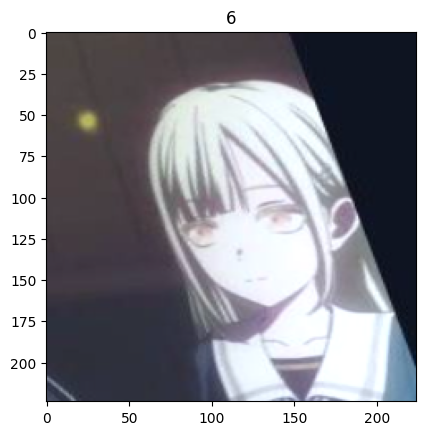

In [6]:
import matplotlib.pyplot as plt
import numpy as np
idx = 8
data, labels = next(iter(train_loader))
print(len(labels), len(data))
print(data.shape)
image_np = data[idx].numpy().transpose((1,2,0))
image_np = image_np * 0.229 + 0.485  # Undo normalization (normalize values back to the original range)

# If the image looks too dark due to normalization, try scaling it
image_np = np.clip(image_np, 0, 1) 
plt.imshow(image_np)
plt.title(labels[idx])

In [7]:
type(data)

torch.Tensor

In [8]:
from src.resnet.resnet_model.mygo_model import ResNet50
import torch.nn as nn
import torch

torch.manual_seed(32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = ResNet50(input_channel=3).to(device)
from timeit import default_timer as timer

# Import tqdm for progress bar
from tqdm.auto import tqdm
from torchmetrics import Accuracy
def accuracy_fn(y_pred,y_true):
    # Get the predicted class by finding the index with the maximum value
    y_pred_class = torch.argmax(y_pred)
    
    # Check how many predictions are correct
    correct_predictions = torch.eq(y_pred_class, y_true).sum().item()
    
    # Calculate the accuracy
    accuracy = (correct_predictions / len(y_true)) * 100
    
    return accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_resnet.parameters(),
                            lr=0.0001)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
epochs = 30
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch = {epoch+1}\n-------------")
    train_loss = 0
    train_acc = 0
    model_resnet.train()
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)          
        y = torch.tensor([int(label) for label in y], dtype=torch.float, device=device)
        y_pred = model_resnet(X).squeeze()
        #calculate loss and costfunction
        acc = accuracy_fn(y_pred=y_pred,y_true=y)
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        train_acc += acc

        #grad to zero
        optimizer.zero_grad()

        #backpropagation
        loss.backward()

        #gradient descent
        optimizer.step()
        if(batch%20 == 0):
            print(f"loss: {loss.item():.5f} ,ACC: {acc:.2f}\n")
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)

    #val dataset
    val_loss = 0
    val_acc = 0
    for batch, (X_val_batch, y_val) in enumerate(val_loader):
        X_val_batch = X_val_batch/255.0
        X_val_batch = X_val_batch.to(device)
        y_val = torch.tensor([int(label) for label in y_val], dtype=torch.float, device=device)
        model_resnet.eval()
        with torch.inference_mode():
            y_val_pred = model_resnet(X_val_batch).squeeze()
            loss  = loss_fn(y_val_pred,y_val)
            acc = accuracy_fn(y_val_pred,y_val)
            val_loss += loss.item()
            val_acc += acc
    val_loss /=len(val_loader)
    val_acc /=len(val_loader)
    
    print(f"Train loss: {train_loss:.5f} ,Train acc: {train_acc:.2f}\n Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}\n")
time_end = timer()
duration = time_end-time_start
print(f"time use:{(duration):2f}seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch = 1
-------------
loss: 185.76344 ,ACC: 6.25

loss: 216.26193 ,ACC: 12.50

loss: 205.17157 ,ACC: 0.00

loss: 213.48933 ,ACC: 12.50

loss: 210.71674 ,ACC: 12.50



  3%|▎         | 1/30 [00:13<06:41, 13.86s/it]

Train loss: 202.49902 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 2
-------------
loss: 232.89746 ,ACC: 12.50

loss: 199.62639 ,ACC: 18.75

loss: 185.76346 ,ACC: 18.75

loss: 224.57968 ,ACC: 18.75

loss: 213.48932 ,ACC: 6.25



  7%|▋         | 2/30 [00:25<05:50, 12.53s/it]

Train loss: 202.42042 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 3
-------------
loss: 238.44263 ,ACC: 0.00

loss: 163.58273 ,ACC: 6.25

loss: 255.07816 ,ACC: 0.00

loss: 182.99086 ,ACC: 12.50

loss: 230.12488 ,ACC: 6.25



 10%|█         | 3/30 [00:36<05:23, 11.99s/it]

Train loss: 202.46329 ,Train acc: 10.70
 Val loss: 192.87803, Val acc: 9.00

Epoch = 4
-------------
loss: 213.48935 ,ACC: 18.75

loss: 227.35228 ,ACC: 6.25

loss: 196.85379 ,ACC: 12.50

loss: 180.21828 ,ACC: 6.25

loss: 249.53299 ,ACC: 0.00



 13%|█▎        | 4/30 [00:48<05:04, 11.73s/it]

Train loss: 202.42756 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 5
-------------
loss: 191.30862 ,ACC: 6.25

loss: 202.39897 ,ACC: 18.75

loss: 174.67310 ,ACC: 6.25

loss: 194.08122 ,ACC: 12.50

loss: 238.44263 ,ACC: 12.50



 17%|█▋        | 5/30 [00:59<04:52, 11.69s/it]

Train loss: 202.46329 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 6
-------------
loss: 224.57968 ,ACC: 0.00

loss: 185.76346 ,ACC: 25.00

loss: 191.30862 ,ACC: 6.25

loss: 205.17155 ,ACC: 0.00

loss: 207.94415 ,ACC: 12.50



 20%|██        | 6/30 [01:12<04:45, 11.90s/it]

Train loss: 202.44185 ,Train acc: 10.57
 Val loss: 192.87803, Val acc: 9.00

Epoch = 7
-------------
loss: 207.94415 ,ACC: 12.50

loss: 188.53604 ,ACC: 6.25

loss: 235.67003 ,ACC: 12.50

loss: 213.48932 ,ACC: 6.25

loss: 205.17155 ,ACC: 25.00



 23%|██▎       | 7/30 [01:24<04:35, 11.98s/it]

Train loss: 202.41327 ,Train acc: 10.57
 Val loss: 192.87803, Val acc: 9.00

Epoch = 8
-------------
loss: 127.53909 ,ACC: 31.25

loss: 185.76344 ,ACC: 6.25

loss: 205.17157 ,ACC: 18.75

loss: 221.80710 ,ACC: 0.00

loss: 174.67310 ,ACC: 18.75



 27%|██▋       | 8/30 [01:36<04:24, 12.01s/it]

Train loss: 202.39898 ,Train acc: 10.70
 Val loss: 192.87803, Val acc: 9.00

Epoch = 9
-------------
loss: 163.58273 ,ACC: 18.75

loss: 202.39899 ,ACC: 12.50

loss: 160.81015 ,ACC: 12.50

loss: 207.94415 ,ACC: 12.50

loss: 230.12486 ,ACC: 6.25



 30%|███       | 9/30 [01:48<04:13, 12.07s/it]

Train loss: 202.33467 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 10
-------------
loss: 268.94110 ,ACC: 12.50

loss: 194.08121 ,ACC: 25.00

loss: 227.35226 ,ACC: 0.00

loss: 243.98782 ,ACC: 6.25

loss: 230.12488 ,ACC: 0.00



 33%|███▎      | 10/30 [02:02<04:10, 12.54s/it]

Train loss: 202.40612 ,Train acc: 10.63
 Val loss: 192.87803, Val acc: 9.00

Epoch = 11
-------------
loss: 243.98781 ,ACC: 6.25

loss: 230.12485 ,ACC: 12.50

loss: 224.57968 ,ACC: 6.25

loss: 199.62639 ,ACC: 12.50

loss: 202.39897 ,ACC: 18.75



 33%|███▎      | 10/30 [02:12<04:25, 13.29s/it]


KeyboardInterrupt: 